# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll training an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd training this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* training the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

## Initialize Local setup

```bash
$ conda install pytorch torchvision torchaudio pytorch-cuda=12.4 -c pytorch -c nvidia
```

In [1]:
# Imports here

import os
import sys
import logging
from datetime import datetime
from collections import OrderedDict

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torch import nn, optim
from torch.autograd import Variable
from torchvision import datasets, transforms, models

# Ensure plots are displayed inline in Jupyter notebooks
%matplotlib inline

In [2]:
# Initialize Logger
log_format = '%(asctime)s - %(name)s - %(levelname)s - %(message)s'
logging.basicConfig(
    level=logging.INFO,
    format=log_format,
)
logger = logging.getLogger(__name__)

file_handler = logging.FileHandler('logs/console.log')
formatter = logging.Formatter(log_format)
file_handler.setFormatter(formatter)

logger.addHandler(file_handler)

logger.info(f"System Information: {sys.version}")
logger.info(f"PyTorch Version {torch.__version__}")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
logger.info(f"CUDA Available: {torch.cuda.is_available()}")
logger.info(f"Selected device: {device}")

2024-08-14 03:38:22,102 - __main__ - INFO - System Information: 3.12.4 | packaged by Anaconda, Inc. | (main, Jun 18 2024, 15:12:24) [GCC 11.2.0]
2024-08-14 03:38:22,103 - __main__ - INFO - PyTorch Version 2.4.0
2024-08-14 03:38:22,185 - __main__ - INFO - CUDA Available: True
2024-08-14 03:38:22,186 - __main__ - INFO - Selected device: cuda:0


## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [3]:
data_dir = 'data'
train_dir = data_dir + '/flowers/train'
valid_dir = data_dir + '/flowers/valid'
test_dir = data_dir + '/flowers/test'
checkpoint_dir = 'checkpoint'

if not os.path.isdir(checkpoint_dir):
    os.makedirs(checkpoint_dir)

if not os.path.isdir(data_dir):
    os.makedirs(data_dir)

In [4]:
# Define constants for normalization and image processing
MEANS = [0.485, 0.456, 0.406]
STD_DEVS = [0.229, 0.224, 0.225]
IMG_MAX_SIZE = 256
IMG_CENTER_CROP=224
IMG_BATCH_SIZE = 64

# Define a common normalization transform
norm = transforms.Normalize(
            mean=MEANS, 
            std=STD_DEVS
        )

# DONE: Define your transforms for the training, validation, and testing sets
data_transformation = {
    "train": transforms.Compose([
        transforms.RandomRotation(45),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(MEANS, STD_DEVS)
    ]),

    "valid": transforms.Compose([
        transforms.Resize(IMG_MAX_SIZE),
        transforms.CenterCrop(IMG_CENTER_CROP),
        transforms.ToTensor(),
        transforms.Normalize(MEANS, STD_DEVS)
    ]),

    "test": transforms.Compose([
        transforms.Resize(IMG_MAX_SIZE),
        transforms.CenterCrop(IMG_CENTER_CROP),
        transforms.ToTensor(),
        transforms.Normalize(MEANS, STD_DEVS)
    ])
}

# DONE: Load the datasets with ImageFolder
image_datasets = {
    'train': datasets.ImageFolder(train_dir, transform=data_transformation['train']),
    'valid': datasets.ImageFolder(valid_dir, transform=data_transformation['valid']),
    'test': datasets.ImageFolder(test_dir, transform=data_transformation['test'])
} 


# DONE: Using the image datasets and the trainforms, define the dataloaders
dataloaders = {
    'train': torch.utils.data.DataLoader(
        image_datasets['train'], 
        batch_size=IMG_BATCH_SIZE, 
        shuffle=True
    ),
    'valid': torch.utils.data.DataLoader(
        image_datasets['valid'], 
        batch_size=IMG_BATCH_SIZE, 
        shuffle=False
    ),
    'test': torch.utils.data.DataLoader(
        image_datasets['test'], 
        batch_size=IMG_BATCH_SIZE, 
        shuffle=False
    ),
}

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [5]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

logger.info(f"Labeled images with {len(cat_to_name)} categories.")

2024-08-14 03:38:22,285 - __main__ - INFO - Labeled images with 102 categories.


# Building and training the classifier

Now that the data is ready, it's time to build and training the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and training a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* training the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to
GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module.

**Note for Workspace users:** If your network is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. Typically this happens with wide dense layers after the convolutional layers. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and training again.

In [6]:
# DONE: Build and train your network

# Set up an Args class to store configuration
class Args:
    def __init__(self):
        self.architecture = 'densenet121'
        self.hidden_layers = None
        self.learning_rate = 0.001
        self.dropout_probability = 0.3
        self.epochs = 5
        self.log_frequency = 50

        self.input_feature_size = {
            'densenet121': 1024,
            'densenet161': 2208,
            'vgg16': 25088,
        }

        self.hidden_layer_size = {
            'densenet121': [500],
            'densenet161': [1000, 500],
            'vgg16': [4096, 4096, 1000],
        }

In [7]:
def classifier_builder(model, args):
    # Freeze the parameters of the pre-trained model
    for param in model.parameters():
        param.requires_grad = False

    # Set the dropout probability
    dropout_probability = args.dropout_probability if args.dropout_probability else 0.5

    # Determine the output size based on the number of classes
    output_size = len(dataloaders['train'].dataset.classes)

    # Activation function, dropout layer, and output layer
    relu = nn.ReLU()
    dropout = nn.Dropout(dropout_probability)
    output = nn.LogSoftmax(dim=1)
    
     # Determine the hidden layer sizes
    if args.hidden_layers:
        hidden_sizes = list(map(int, args.hidden_layers.split(',')))
    else:
        hidden_sizes = args.hidden_layer_size[args.architecture.lower()]

     # Building the classifier layers
    layers = [nn.Linear(args.input_feature_size[args.architecture.lower()], hidden_sizes[0]), relu]

    if 'vgg' in args.architecture.lower():
        layers.append(dropout)

    if len(hidden_sizes) > 1:
        for h1, h2 in zip(hidden_sizes[:-1], hidden_sizes[1:]):
            layers.append(nn.Linear(h1, h2))
            layers.append(relu)
            if 'vgg' in args.architecture.lower():
                layers.append(dropout)

    # Add the final output layer
    layers.append(nn.Linear(hidden_sizes[-1], output_size))
    layers.append(output)

    # Assign the classifier to the model
    model.classifier = nn.Sequential(*layers)
    
    return model

In [8]:
# Load a pre-trained model and override with own classifier
args = Args()

model = models.__dict__[args.architecture.lower()](weights=True)    
model = classifier_builder(model, args)

logger.info(f"Model architecture:{ model }")
logger.debug(model.classifier)

/home/amalsyahreza/.conda/envs/udacity_aipnd_project/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
2024-08-14 03:38:22,538 - __main__ - INFO - Model architecture:DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [9]:
# DONE: Do validation on the test set

def validate(model, dataloaders, criterion, device):
    model.eval()  # Set model to evaluation modeyp
    accuracy = 0
    validation_loss = 0
    
    with torch.no_grad():  # Disable gradient computation
        for images, labels in dataloaders['valid']:
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            validation_loss += criterion(outputs, labels).item()
            
            # Calculate accuracy
            probabilities = torch.exp(outputs)
            predictions = probabilities.max(dim=1)[1]
            equality = (predictions == labels)
            accuracy += equality.type(torch.FloatTensor).mean().item()
    
    # Compute average loss and accuracy
    validation_loss /= len(dataloaders['valid'])
    accuracy /= len(dataloaders['valid'])

    logger.debug(f"Validation Loss: {validation_loss:.3f}")
    logger.debug(f"Accuracy: {accuracy*100:.2f}%")

    return validation_loss, accuracy

In [10]:
# training
def train(model, dataloaders, optimizer, criterion, epochs, log_frequency, learning_rate):
    logger.info(f"Training model on {device}")

    model.to(device)
    start_time = datetime.now()
    
    logger.info(f"epochs: {epochs}")
    logger.info(f"log_frequency: {log_frequency}")
    logger.info(f"learning_rate: {learning_rate}")

    counter = 0
    
    for i in range(epochs):
        model.train()
        running_loss = 0

        for images, labels in iter(dataloaders['train']):
            counter +=1

            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()

            output = model.forward(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if counter % log_frequency == 0:
                model.eval()
                
                with torch.no_grad():
                    validation_loss, accuracy = validate(model, dataloaders, criterion, device)

                valid_data_length = len(dataloaders['valid'])

                logger.info(f"Epoch: {i+1} / {epochs}")
                logger.info(f"Training Loss: {running_loss/log_frequency:.3f}")
                logger.info(f"Validation Loss: {validation_loss/valid_data_length:.3f}")
                logger.info(f"Accuracy: {accuracy*100:.2f}%")

                running_loss = 0

                model.train()
        
    run_time = datetime.now() - start_time
    
    logger.info(f"Training completed after {run_time}")
    
    return model

In [11]:
# Model Training

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=args.learning_rate)  

model = train(
    model, 
    dataloaders, 
    optimizer, 
    criterion, 
    args.epochs, 
    args.log_frequency, 
    args.learning_rate
)

2024-08-14 03:38:22,641 - __main__ - INFO - Training model on cuda:0
2024-08-14 03:38:22,795 - __main__ - INFO - epochs: 5
2024-08-14 03:38:22,796 - __main__ - INFO - log_frequency: 50
2024-08-14 03:38:22,796 - __main__ - INFO - learning_rate: 0.001
2024-08-14 03:38:45,245 - __main__ - INFO - Epoch: 1 / 5
2024-08-14 03:38:45,245 - __main__ - INFO - Training Loss: 3.784
2024-08-14 03:38:45,246 - __main__ - INFO - Validation Loss: 0.195
2024-08-14 03:38:45,246 - __main__ - INFO - Accuracy: 47.59%
2024-08-14 03:39:06,790 - __main__ - INFO - Epoch: 1 / 5
2024-08-14 03:39:06,791 - __main__ - INFO - Training Loss: 2.143
2024-08-14 03:39:06,791 - __main__ - INFO - Validation Loss: 0.099
2024-08-14 03:39:06,791 - __main__ - INFO - Accuracy: 71.86%
2024-08-14 03:39:28,899 - __main__ - INFO - Epoch: 2 / 5
2024-08-14 03:39:28,899 - __main__ - INFO - Training Loss: 1.198
2024-08-14 03:39:28,900 - __main__ - INFO - Validation Loss: 0.061
2024-08-14 03:39:28,900 - __main__ - INFO - Accuracy: 82.55%


In [12]:
def test(model, dataloaders, criterion, device):
    model.to(device)
    model.eval()

    test_loss = 0.0
    correct = 0
    total = 0

    start_time = datetime.now()

    with torch.no_grad(): # Disable gradient calculation in testing
        for images, labels in dataloaders['test']:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            # Calculate accuracy
            _, predictions = torch.max(outputs, 1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    # Calculate average loss and accuracy
    test_loss /= len(dataloaders['test'])
    accuracy = correct / total

    # Log the results
    logger.info(f"Test Loss: {test_loss:.3f}")
    logger.info(f"Correct Prediction: {correct} / {total}")
    logger.info(f"Test Accuracy: {accuracy*100:.2f}%")

    run_time = datetime.now() - start_time
    logger.info(f"Test completed in {run_time}")

    # Store accuracy in the model object if needed
    model.test_accuracy = accuracy

    return model

# Run the test function

test(model, dataloaders, criterion, device)

2024-08-14 03:42:10,685 - __main__ - INFO - Test Loss: 0.362
2024-08-14 03:42:10,685 - __main__ - INFO - Correct Prediction: 738 / 819
2024-08-14 03:42:10,686 - __main__ - INFO - Test Accuracy: 90.11%
2024-08-14 03:42:10,686 - __main__ - INFO - Test completed in 0:00:04.616431


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['training'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['training'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [13]:
# DONE: Save the checkpoint 

# Save the model checkpoint
model.class_to_idx = dataloaders['train'].dataset.class_to_idx

# Prepare checkpoint data
checkpoint = {
    'architecture': args.architecture,
    'classifier': model.classifier,
    'epochs': args.epochs,
    'dropout_probability': args.dropout_probability,
    'learning_rate': args.learning_rate,
    'train_batch_size': dataloaders['train'].batch_size,
    'valid_batch_size': dataloaders['valid'].batch_size,
    'state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'class_to_idx': model.class_to_idx
}

# Generate checkpoint filename
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
checkpoint_filename = f"{timestamp}_{args.architecture}.pth"
checkpoint_path = os.path.join(checkpoint_dir, checkpoint_filename)

# Ensure the target directory exists
os.makedirs(checkpoint_dir, exist_ok=True)

# Save the checkpoint
try:
    torch.save(checkpoint, checkpoint_path)
    logger.info(f"Checkpoint saved successfully: {checkpoint_filename} in {checkpoint_dir}")
except Exception as e:
    logger.error(f"Failed to save checkpoint: {str(e)}")

2024-08-14 03:42:10,771 - __main__ - INFO - Checkpoint saved successfully: 20240814_034210_densenet121.pth in checkpoint


## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [14]:
# TODO: Write a function that loads a checkpoint and rebuilds the model

def checkpoint_loader(filepath, device):
    """
    Load a model and its state from a checkpoint file.
    
    Parameters:
    - filepath (str): Path to the checkpoint file.
    - device (torch.device): Device to load the model onto (CPU or GPU).

    Returns:
    - model (nn.Module): The model with the loaded state.
    - args (Namespace): The arguments used for model configuration.
    """
    
    # Load checkpoint to the appropriate device
    checkpoint = torch.load(filepath, map_location=device)

    # Extract model architecture and initialize
    architecture = checkpoint['architecture']
    model = models.__dict__[architecture.lower()](pretrained=True)
    
    # Update model with the checkpoint state
    model.classifier = checkpoint['classifier']
    model.class_to_idx = checkpoint['class_to_idx']
    model.load_state_dict(checkpoint['state_dict'])

    # Update args with the architecture from checkpoint
    args.architecture = architecture
    args.dropout_probability = checkpoint['dropout_probability']
    args.learning_rate = checkpoint['learning_rate']
    args.epochs = checkpoint['epochs']
    args.train_batch_size = checkpoint['train_batch_size']
    args.valid_batch_size = checkpoint['valid_batch_size']

    return model, args

In [15]:
checkpoint_filepath = 'checkpoint/20240813_195458_densenet121.pth'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

args = Args()

try:
    # Attempt to load the model and configuration from the checkpoint
    model_load, args = checkpoint_loader(checkpoint_filepath, device)
    
    # Print model and args information
    logger.debug(f"Model Architecture: {args.architecture}")
    logger.debug(f"Dropout Probability: {args.dropout_probability}")
    logger.debug(f"Learning Rate: {args.learning_rate}")
    logger.debug(f"Epochs: {args.epochs}")
    logger.debug(f"Train Batch Size: {args.train_batch_size}")
    logger.debug(f"Valid Batch Size: {args.valid_batch_size}")

    # Optionally, print model details
    logger.info("Model successfully loaded:")
    logger.debug(model_load)
    
except FileNotFoundError:
    logger.error(f"Error: The checkpoint file '{checkpoint_filepath}' was not found.")
except KeyError as e:
    logger.error(f"Error: Missing key in the checkpoint file: {str(e)}")
except Exception as e:
    logger.error(f"An unexpected error occurred: {str(e)}")

/tmp/ipykernel_2403702/228858088.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filepath, map_location=device)
/home/amalsyahreza/.conda/envs/u

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [16]:
# DONE: Process a PIL image for use in a PyTorch model

TEST_IMAGE_PATH='/102/image_08041.jpg'

def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
           
    pil_image = Image.open(image).convert("RGB")
    
    # Any reason not to let transforms do all the work here?
    in_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(MEANS, STD_DEVS)])

    pil_image = in_transforms(pil_image)

    return pil_image

check_image = process_image(valid_dir + TEST_IMAGE_PATH )

logger.info(f"{type(check_image)}")

2024-08-14 03:42:11,034 - __main__ - INFO - <class 'torch.Tensor'>


To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [17]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [18]:
# DONE: Implement the code to predict the class from an image file

def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # Set model to evaluation mode
    model.eval()

    # Ensure the model is on the same device as the image tensor
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Preprocess and load the image (assume the function returns a tensor)
    image_tensor = process_image(image_path).unsqueeze(0).to(device)

    # Perform forward pass to get predictions
    with torch.no_grad():
        output = model(image_tensor)
        top_probabilities, top_indices = torch.topk(output, topk)
        
        # Convert probabilities to exponential form (softmax)
        top_probabilities = top_probabilities.exp()

    # Convert tensor results to numpy arrays
    top_probabilities = top_probabilities.cpu().numpy()[0]
    top_indices = top_indices.cpu().numpy()[0]
    
    # Map indices to class labels
    idx_to_class = {v: k for k, v in model.class_to_idx.items()}
    top_classes = [idx_to_class[idx] for idx in top_indices]

    return top_probabilities, top_classes

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [19]:
# DONE: Display an image along with the top 5 classes

def image_displayer(valid_image_path, correct_class):
    top_probabilities, top_classes = predict(valid_image_path, model_load)

    logger.info(f"Correct Class: {correct_class}")
    logger.info(f"Top Probabilities: {top_probabilities}")
    logger.info(f"Top Classes: {top_classes}")

    label = top_classes[0]

    # Initialize the figure
    plt.figure(figsize=(10,10))

    # Image subplot
    subplot_img = plt.subplot2grid((5,5), (0,0), colspan=5, rowspan=3)
    image = Image.open(valid_image_path)
    subplot_img.axis('off')
    subplot_img.set_title(f'{cat_to_name[label]}')
    subplot_img.imshow(image)

    # Graph subplot
    subplot_graph = plt.subplot2grid((5,5), (3,0), colspan=5, rowspan=2)

    labels = []

    for class_idx in top_classes:
        labels.append(cat_to_name[class_idx])

    y = np.arange(5)
    subplot_graph.set_yticks(y)
    subplot_graph.set_yticklabels(labels)
    subplot_graph.set_xlabel('Probability')
    subplot_graph.invert_yaxis()
    subplot_graph.barh(y, top_probabilities, xerr=0, align='center', color='green')

    plt.show()

    logger.info(f'Correct classification: {correct_class}')
    logger.info(f'Correct prediction: {correct_class == cat_to_name[label]}')

2024-08-14 03:42:11,311 - __main__ - INFO - Correct Class: magnolia
2024-08-14 03:42:11,312 - __main__ - INFO - Top Probabilities: [0.96677387 0.01481611 0.008917   0.00280322 0.00241016]
2024-08-14 03:42:11,313 - __main__ - INFO - Top Classes: ['87', '88', '73', '78', '67']


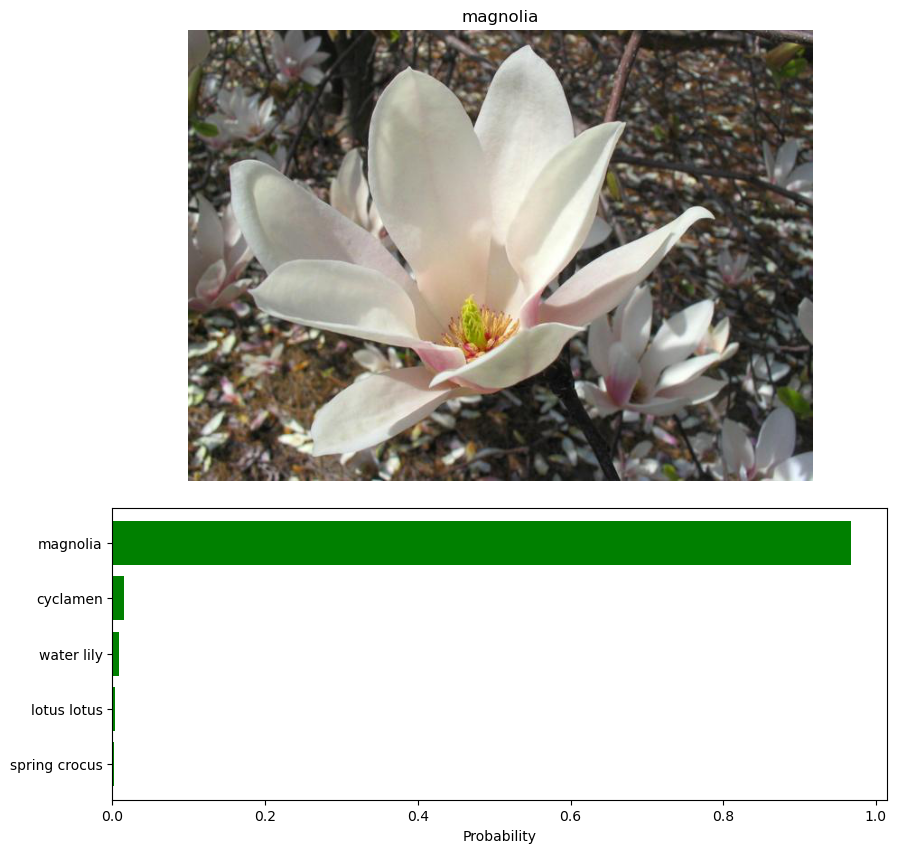

2024-08-14 03:42:11,540 - __main__ - INFO - Correct classification: magnolia
2024-08-14 03:42:11,541 - __main__ - INFO - Correct prediction: True


In [20]:
index = '87'
valid_image_path = valid_dir + '/' + index + '/image_05484.jpg'
correct_class = cat_to_name[index]

image_displayer(valid_image_path, correct_class)